In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt


from HOTS.Monitor import GenerateAM, DisplayAM
from HOTS.Event import Event, SimpleAlphabet, LoadGestureDB
from HOTS.STS import STS
from HOTS.Layer import ClusteringLayer, FilterNHBD
from HOTS.Monitor import DisplayImage, DisplaySurface3D, DisplaySurface2D, DisplayConvergence
from HOTS.Tools import SaveObject, LoadObject
from HOTS.Classifier import Classifier
from HOTS.Network import Network
from HOTS.KmeansHomeoCluster import KmeansHomeo
from HOTS.KmeansCluster2 import KmeansMaro2

In [3]:
tau = 0.02
R = 2
nb_cluster = [4,8,16]
eta_list = [1e-5,1e-5,1e-5] 
eta_homeo_list = [1e-3,1e-3,1e-3]
C_list = [6,18,40] 
ImageSize = (32,32)
DataPath = '../Data/ExtractedStabilized.mat'
LabelPath = '../Data/alphabet_label.pkl'

In [4]:
image_list = [1, 32, 19, 22, 29]
event0 = Event(ImageSize=(32,32),OutOnePolarity=False)

event0.LoadFromMat('../Data/ExtractedStabilized.mat',image_number=image_list)

In [5]:
SpTe_Layer1= STS(tau=tau, R=R,verbose=0)
Surface_Layer1 = SpTe_Layer1.create(event = event0,kernel='linear')

In [6]:
print(Surface_Layer1.shape)

(74457, 50)


In [7]:
print(event0.address.shape)
print(event0.polarity.shape)
print(event0.time.shape)
print(type(event0.ListPolarities))

(74457, 2)
(74457,)
(74457,)
<class 'numpy.ndarray'>


In [8]:
import HOTS.libUnpackAtis as ua
import HOTS.libDataHelper as dh

In [9]:
settingsFile = "/Users/boutin.v/Documents/DataBase/GEST/newlayer_digit.hotsnetwork"
specs = dh.superLoadHOTSNetworkSettingsFromFile(settingsFile, True)
dbspecs = dh.superReadDB(specs.db_file, specs.db_path)

------ Loaded settings ------
Enable viewer: True (Port: 3330, update 8)
 
Number of polarities of the input: 1
Number of dimensions and sizes: 2, [304 240]
Number of layers: 1
> 8, 10000.0, 2
Number of fixed layers: 0
 
Data file: none
DB file: /Users/boutin.v/Documents/DataBase/GEST/testoids_1.db
DB path: /Users/boutin.v/Documents/DataBase/GEST/complete_chris_db/
Workdir path: 
Save id: 
------ End of settings ------
 
840 files in the DB.


In [10]:
nb_of_file = 2
n_learn = np.sum(np.array(dbspecs.dblabels) == 1)
for idf, dblabel in enumerate(dbspecs.dblabels):
    if idf % 10 == 0:
        print('file {0}/{1}'.format(idf+1, n_learn))
    filepath = dbspecs.path + dbspecs.filenames[idf]
    event = LoadGestureDB(filepath)
    if idf == nb_of_file:
        break

file 1/780


(42921, 2)


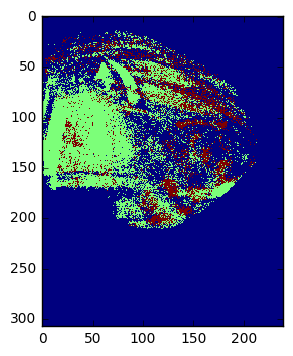

In [11]:
image = np.zeros((308,240))-1
target0 = 0
target = 60000
print(event.address.shape)
image[event.address[target0:target,0],event.address[target0:target,1]] \
    = event.polarity[target0:target]
plt.imshow(image)

In [12]:
nb_dico = 14
R = 2
SpTe_Layer1 = STS(tau=0.03, R=R, verbose=0,initial_time=1)
#ClusterLayer1 = KmeansMaro2(4, to_record=True, verbose=0,eta=1)

In [13]:
res_list=list()
coeff_list = list()
#eta = 0.1
nb_of_file = 100
n_learn = np.sum(np.array(dbspecs.dblabels) == 1)
Prototype1 = np.random.rand(nb_dico,25)
nb_proto = np.zeros(nb_dico)
for idf, dblabel in enumerate(dbspecs.dblabels):
    if idf % 10 == 0:
        print('file {0}/{1}'.format(idf+1, n_learn))
    
    filepath = dbspecs.path + dbspecs.filenames[idf]
    event = LoadGestureDB(filepath, OutOnePolarity=True)
    Surface_Layer1 = SpTe_Layer1.create(event = event,kernel='linear')
    filt = np.sum(Surface_Layer1, axis = 1) > 2*R
    Surface_Layer2 = Surface_Layer1[filt,:] 
    
    res = np.zeros((Surface_Layer2.shape[0]))
    for idx, Si in enumerate(Surface_Layer2):
        Distance_to_proto = np.linalg.norm(Si - Prototype1,ord=2,axis=1)
        closest_proto_idx = np.argmin(Distance_to_proto)
        Ck = Prototype1[closest_proto_idx,:].copy()
        pk = nb_proto[closest_proto_idx]
        alpha = 1/(1+pk)
        beta = np.dot(Ck, Si)/(np.sqrt(np.dot(Si, Si))*np.sqrt(np.dot(Ck, Ck)))
        #Ck_t = Ck + eta*alpha*beta*(Si-Ck)
        Ck_t = Ck + alpha*beta*(Si-Ck)
        res[idx] = np.linalg.norm(Si-Ck_t,ord=2)
        
        #Ck_t = Ck + self.eta*beta*(Si-Ck)

        nb_proto[closest_proto_idx] += 1
        Prototype1[closest_proto_idx, :] = Ck_t
        coeff_list.append(alpha*beta)
        #if idx%10000==0:
        #    print(alpha)
        #Prototype1 /= np.linalg.norm(Prototype1,ord=2,axis=1)[:,None]
    res_list.append(np.mean(res))

    
    if idf == nb_of_file:
        break
    
#filepath = 
#ts, c, p, removed_events = ua.readATIS_td(filepath, orig_at_zero = True, drop_negative_dt = True, verbose = False)

file 1/780
file 11/780
file 21/780
file 31/780
file 41/780
file 51/780
file 61/780
file 71/780
file 81/780
file 91/780
file 101/780


In [14]:
a = Surface_Layer2[243,:].reshape(2,25)
plt.imshow(a[0,:].reshape(5,5),cmap='gray')
print(a[0,:].reshape(5,5))

ValueError: cannot reshape array of size 25 into shape (2,25)

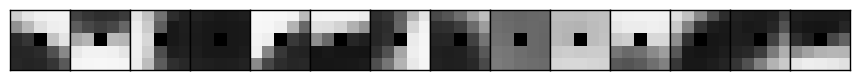

In [15]:
DisplaySurface2D(Prototype1,nb_polarities=1)

In [ ]:
print(nb_proto)

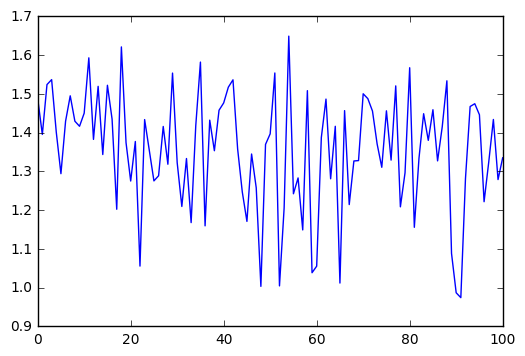

In [16]:
plt.plot(res_list)

In [ ]:
te = SpTe_Layer1.ListOfTimeMatrix[0,:,:]
plt.imshow(te)

In [ ]:
def GenerateHistogram(dico,database_spec):
    nb_dico = dico.shape[0]
    list_of_histo = list
    print(nb_dico)
    for idf, dblabel in enumerate(dbspecs.dblabels):
        histo = np.zeros(nb_dico)
        if idf % 10 == 0:
            print('file {0}/{1}'.format(idf+1, n_learn))

        filepath = dbspecs.path + dbspecs.filenames[idf]
        event = LoadGestureDB(filepath, OutOnePolarity=True)
        Surface_Layer1 = SpTe_Layer1.create(event = event,kernel='linear')
        filt = np.sum(Surface_Layer1, axis = 1) > 2*R
        Surface_Layer2 = Surface_Layer1[filt,:] 
        
        for idx, Si in enumerate(Surface_Layer2):
            Distance_to_proto = np.linalg.norm(Si - Prototype1,ord=2,axis=1)
            closest_proto_idx = np.argmin(Distance_to_proto)
            histo[closest_proto_idx] += 1
        list_of_histo.append(histo)

In [ ]:
DisplaySurface2D(Prototype1,nb_polarities=2)
#DisplayConvergence(ClusterLayer1,to_display=['error','histo'])

In [ ]:
stop_here

In [ ]:
for idf, dblabel in enumerate(dbspecs.dblabels):
    if idf % 10 == 0:
        print('file {0}/{1}'.format(idf+1, n_learn))
    filepath = dbspecs.path + dbspecs.filenames[idf]
    event = LoadGestureDB(filepath)
    Surface_Layer1 = SpTe_Layer1.create(event = event0,kernel='linear')

In [ ]:
print(ClusterLayer1.record)

In [ ]:
print(Surface_Layer1.shape)
print(event.time[4])

In [ ]:
a = np.random.rand(4,50)
print(a.shape)
print(a)

In [ ]:
print(np.max(c[:,0]))
print(np.max(c[:,1]))

In [ ]:
100 % 100